# Kronecker-based Compressed Sensing signal recovery

In this notebook we explore the _compression_ and _recovery_ of aCompressive Sensing _compressible_ signal through __Compressive Sensing__ with __Kronecker Technique__

### Generate a random sparse signal

In [83]:
import numpy as np

def sparseSignal(N, K=None, sigma_noise=0.01, sigma_active=0.5, fixedActiveValue=None):
    """
    Generates a K-sparse signal with N-K inactive components, chosen randomly. The inactive components 
    are nearly zero, while the active components are either a fixed value or generated from a Gaussian 
    distribution.

    Parameters:
    ----------
    N : int
        The total number of components in the signal.
    
    K : int, optional
        The number of active (non-zero) components in the signal. If not provided, defaults to 10% of `N`.
    
    sigma_noise : float, optional (default=0.01)
        The standard deviation of the Gaussian noise added to all components (both active and inactive).
    
    sigma_active : float, optional (default=0.5)
        The standard deviation of the Gaussian noise for generating the active components, if `fixedActiveValue` 
        is not provided.
    
    fixedActiveValue : float, optional
        If provided, this fixed value is assigned to all active components instead of generating them randomly.

    Returns:
    -------
    signal : numpy array
        The generated signal of length `N` with `K` active components.
    
    active_indices : numpy array
        The indices of the active components in the signal.

    Notes:
    -----
    - The signal is constructed by first randomly selecting `K` indices as active components.
    - If `fixedActiveValue` is `None`, the active components are drawn from a Gaussian distribution 
      with standard deviation `sigma_active`.
    - Gaussian noise with standard deviation `sigma_noise` is then added to all components, ensuring 
      the inactive components have small random values near zero.

    """

    if K is None:
        N = int(N)
        K = int(0.1 * N)
    else:
        N = int(N)
        K = int(K)

    active_indexes = np.zeros(N)
    active_indexes[:K] = 1
    np.random.shuffle(active_indexes)

    signal = np.zeros(N)
    
    if fixedActiveValue is None:
        # Generate active components with Gaussian noise
        signal[active_indexes == 1] = np.random.randn(K) * sigma_active
    else:
        # Use fixed value for active components
        signal[active_indexes == 1] = fixedActiveValue
    
    # Add Gaussian noise to both active and inactive components
    signal += np.random.randn(N) * sigma_noise

    return signal, np.where(active_indexes == 1)[0]


Test the above function

Maximum value in the signal: 0.6286497254652504


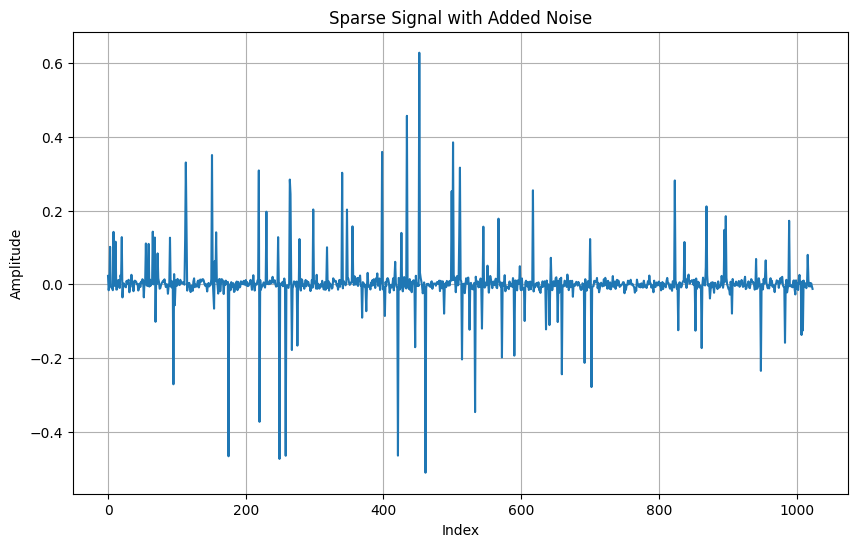

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Parameters for the sparse signal
N = 2 ** 10
K = int(0.1 * N)
sigma_noise = 0.01
sigma_active = 0.2
fixedActiveValue = None

# Generate the sparse signal
x, active_indices = sparseSignal(N, K, sigma_noise, sigma_active, fixedActiveValue)

# Display the full signal array (optional, since it's very large)
#np.set_printoptions(threshold=np.inf)  # Setting the threshold to infinity to display the full array
#print("Signal: ", x)
#print("Active indices: ", active_indices)

# Print the maximum value in the signal
print("Maximum value in the signal:", np.max(x))

# Plot the sparse signal
plt.figure(figsize=(10, 6))
plt.plot(x)
plt.title('Sparse Signal with Added Noise')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



#### Reconstruction method: Smooth-L0 (SL0)

In [85]:
import numpy as np

def SL0(y, A, sigma_min, sigma_decrease_factor=0.5, mu_0=2, L=3, A_pinv=None, showProgress=False):
    """
    Returns the sparsest vector `s` that satisfies the underdetermined system of 
    linear equations `A @ s = y`, using the Smoothed L0 (SL0) algorithm.

    Parameters:
    ----------
    y : numpy array
        The observed vector (Mx1), where M is the number of rows in `A`.
    
    A : numpy array
        The measurement matrix (MxN), which should be 'wide', meaning it has more 
        columns than rows (N > M). The number of rows in `A` must match the length 
        of `y`.
    
    sigma_min : float
        The minimum value of `sigma`, which determines the stopping criterion for 
        the algorithm. It should be chosen based on the noise level or desired 
        accuracy.
    
    sigma_decrease_factor : float, optional (default=0.5)
        The factor by which `sigma` is decreased in each iteration. This should be 
        a positive value less than 1. Smaller values lead to quicker reduction of 
        `sigma`, possibly at the cost of accuracy for less sparse signals.
    
    mu_0 : float, optional (default=2)
        The scaling factor for `mu`, where `mu = mu_0 * sigma^2`. This parameter 
        influences the convergence rate of the algorithm.
    
    L : int, optional (default=3)
        The number of iterations for the inner loop (steepest descent). Increasing 
        `L` can improve the precision of the result but also increases computational 
        cost.
    
    A_pinv : numpy array, optional
        The precomputed pseudoinverse of the matrix `A`. If not provided, it will be 
        calculated within the function as `np.linalg.pinv(A)`. Providing this value 
        is beneficial if the function is called repeatedly with the same `A`.
    
    showProgress : bool, optional (default=False)
        If `True`, the function prints the current value of `sigma` during each 
        iteration, which helps monitor the convergence process.

    Returns:
    -------
    s : numpy array
        The estimated sparse signal (Nx1) that best satisfies the equation `A @ s = y`.

    Notes:
    -----
    - The algorithm works by iteratively reducing `sigma` in a geometric sequence, 
      starting with `sigma = 2 * max(abs(s))` and ending with `sigma_min`. At each 
      step, the function adjusts `s` to minimize the L0-norm by smoothing it using 
      a Gaussian kernel.
    
    - The choice of `sigma_min` is crucial: for noiseless cases, a smaller `sigma_min` 
      yields a sparser solution; for noisy cases, `sigma_min` should be a few times 
      the standard deviation of the noise in `s`.

    - If `A_pinv` is precomputed and passed as an argument, the function becomes 
      more efficient, especially in scenarios where it is called repeatedly with the 
      same `A`.

    """

    if A_pinv is None:
        A_pinv = np.linalg.pinv(A)

    # Initialize the variables
    s = A_pinv @ y
    sigma = 2 * max(np.abs(s))

    # Define lambda function for delta
    OurDelta = lambda s, sigma: s * np.exp(-s**2 / sigma**2)
 
    # Main loop
    while sigma > sigma_min:
        for i in range(L):
            delta = OurDelta(s, sigma)
            s = s - mu_0 * delta
            s = s - A_pinv @ (A @ s - y)
        
        if showProgress:
            print(f'sigma: {sigma}')

    sigma = sigma * sigma_decrease_factor

    return s


Test above code


In [86]:
y = np.array([1, 2])
A = np.array([[1, 2, 3], [4, 5, 6]])
s = SL0(y, A, sigma_min=0.01)
print(s)
   

KeyboardInterrupt: 